Paper : https://www.sciencedirect.com/science/article/pii/S0014482718306438?via%3Dihub

GEO : https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi

In [12]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from node2vec import Node2Vec

https://github.com/neocaleb/NetworkPractice/blob/master/expression2undirected_network.py

In [13]:
#Load expression data
data_table = pd.read_table("/content/drive/MyDrive/Colab Notebooks/GSE116341_single_and_population_P_falciparum_iRBCs_expression.txt",sep='\t',index_col=0)
# data_table = data_table.iloc[:,:180] # sc.iRBC
data_table = data_table.iloc[:,180:] # population.iRBC
data_matrix = np.array(data_table)
cell_id = np.array(data_table.columns)
gene_name = np.array(data_table.index)
log_data = np.log2(data_matrix+1)

In [14]:
#Load annotation data
data_table = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/GSE116341_series_matrix_fixed.txt",sep='\t', error_bad_lines=False, index_col=0)
annotations = np.array(data_table)
cell_type = annotations[6]

In [15]:
#Gene filtering
existenceCutoff = 0.1
geneFilter = np.sum(log_data>1,1)/len(log_data[0])>0
log_data = log_data[geneFilter,:]
gene_name = gene_name[geneFilter]

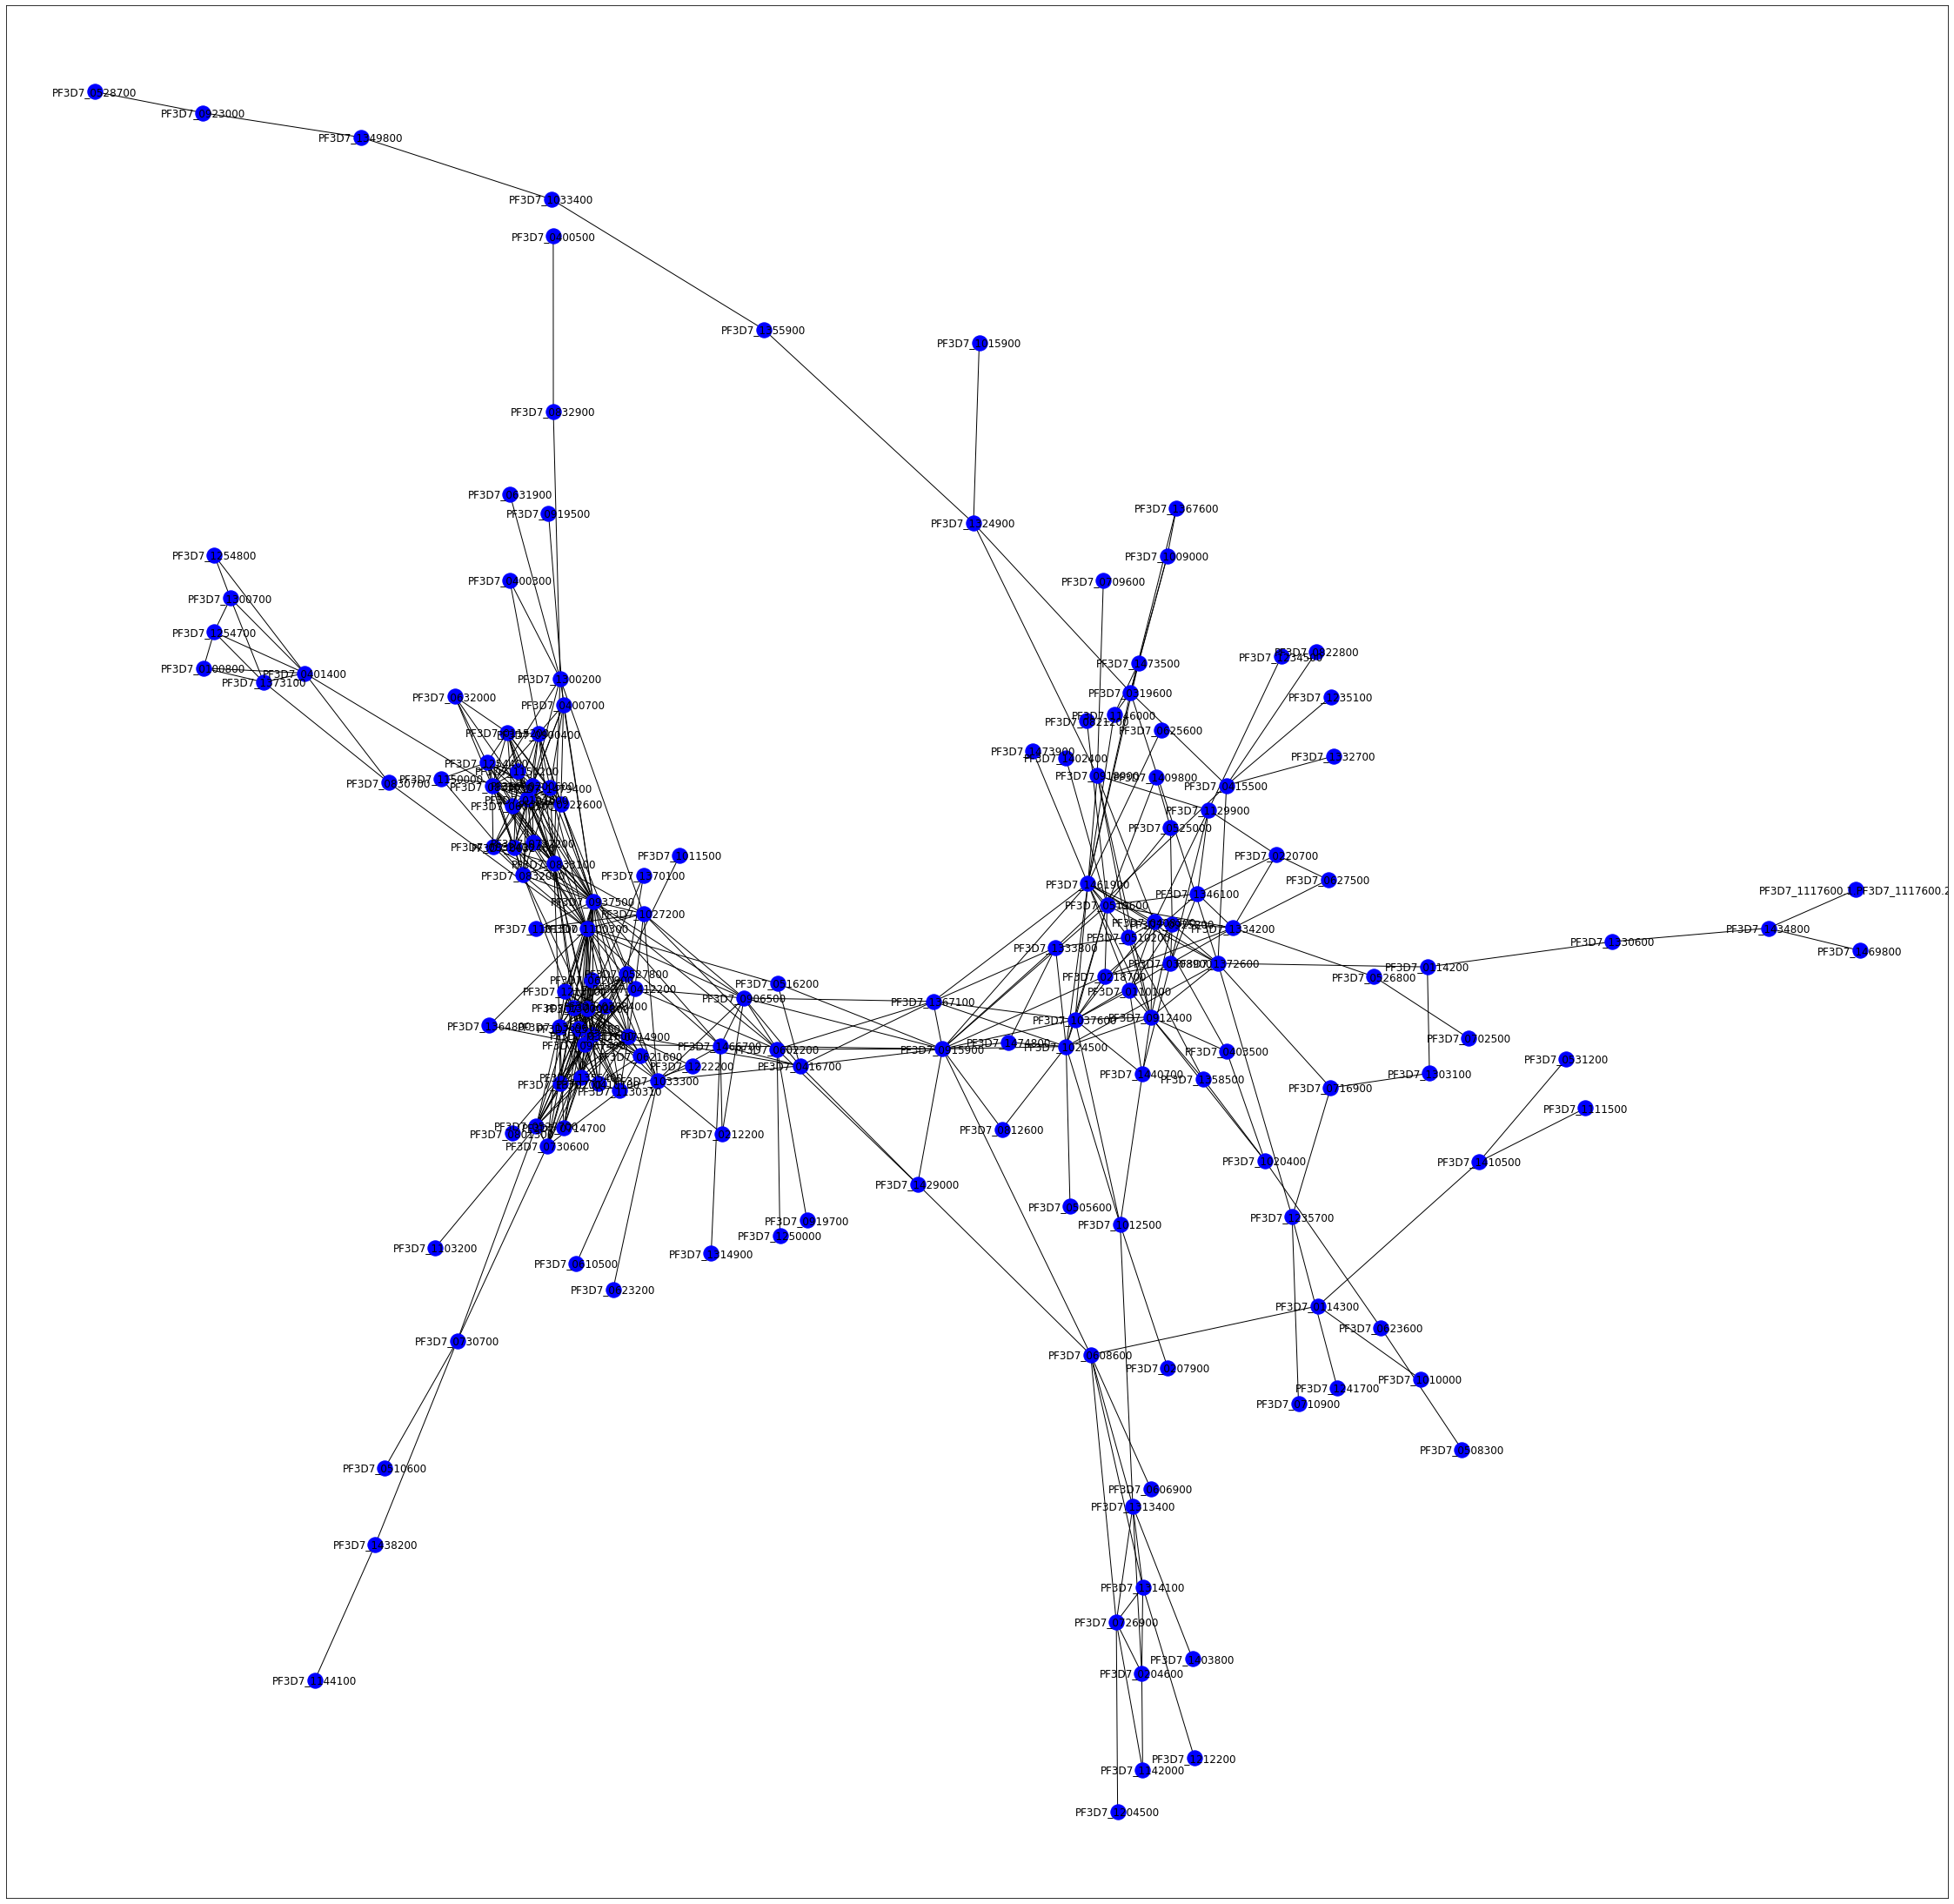

In [26]:
#### make correlation network 4 gene
#Sort by CV
log_data_mean4gene = np.mean(log_data,axis=1)
log_data_std4gene = np.std(log_data,axis=1)
log_data_CV4gene = log_data_std4gene/log_data_mean4gene
sortIndex = np.argsort(log_data_CV4gene)
sortIndex = sortIndex[::-1]
highCutoff = 4600
#Calculation correlation matrix
log_data_corr4gene = np.corrcoef(log_data[sortIndex[0:highCutoff],:])
np.fill_diagonal(log_data_corr4gene,0)
corrCutoff = 0.9
log_data_corr4gene[np.abs(log_data_corr4gene)<corrCutoff] = 0
#Make a network
corrNetwork4gene = nx.to_networkx_graph(log_data_corr4gene,create_using=nx.Graph)
#Node labeling
node_labels = {}
for i in range(highCutoff):
    node_labels[i] = gene_name[sortIndex[i]]
corrNetwork4gene = nx.relabel_nodes(corrNetwork4gene,node_labels)
lcc_node = max(nx.connected_components(corrNetwork4gene),key=len)
corrNetwork4geneLcc = corrNetwork4gene.subgraph(lcc_node)
plt.rcParams["figure.figsize"] = (40, 40)
nx.draw_networkx(corrNetwork4geneLcc, node_color='blue')

In [17]:
G = corrNetwork4geneLcc

In [18]:
print(nx.info(G))
h, a = nx.hits(G)
# print(G.neighbors(7))

Name: 
Type: Graph
Number of nodes: 161
Number of edges: 497
Average degree:   6.1739
{'PF3D7_1303100': 7.39014805227673e-07, 'PF3D7_0632400': 0.012686862018117367, 'PF3D7_0401400': 0.0018179264501944907, 'PF3D7_0714700': 0.013055379576573926, 'PF3D7_1403800': 1.3279422235043674e-06, 'PF3D7_1103200': 0.0014496302653590402, 'PF3D7_0220700': 6.152997284518602e-06, 'PF3D7_0631900': 0.000641956495515051, 'PF3D7_0319600': 3.583909681291299e-05, 'PF3D7_0623200': 0.001005136814757519, 'PF3D7_1033400': 2.122390489382046e-08, 'PF3D7_0408300': 6.913008746975561e-05, 'PF3D7_1358500': 1.1023515106841764e-05, 'PF3D7_0925800': 4.406341778945912e-05, 'PF3D7_0918900': 3.994734638074117e-05, 'PF3D7_1101300': 0.0036902267232434725, 'PF3D7_0415500': 2.740378423342776e-05, 'PF3D7_0400700': 0.00978901228536551, 'PF3D7_1367600': 2.6922965271215054e-06, 'PF3D7_1011500': 0.0019884650456971696, 'PF3D7_1349800': 1.3875045540214558e-09, 'PF3D7_0732200': 0.017945160420142013, 'PF3D7_0919500': 0.000635643121499707

https://frhyme.github.io/machine-learning/node2vec_lib/

In [19]:
from sklearn.cluster import KMeans

node2vec = Node2Vec(graph=G,
                    dimensions=50,
                    walk_length=10,
                    p = 1,
                    q = 0.0001,
                    weight_key=None,
                    num_walks=2000, 
                    workers=1,
                   )

model = node2vec.fit(window=2)

Generating walks (CPU: 1):   0%|          | 3/2000 [00:00<01:29, 22.21it/s]

Generating walks (CPU: 1): 100%|██████████| 2000/2000 [02:16<00:00, 14.67it/s]


In [20]:
K = 6
kmeans = KMeans(n_clusters=K, random_state=0).fit(model.wv.vectors)

for n, label in zip(model.wv.index2entity, kmeans.labels_):
    G.nodes[n]['label'] = label

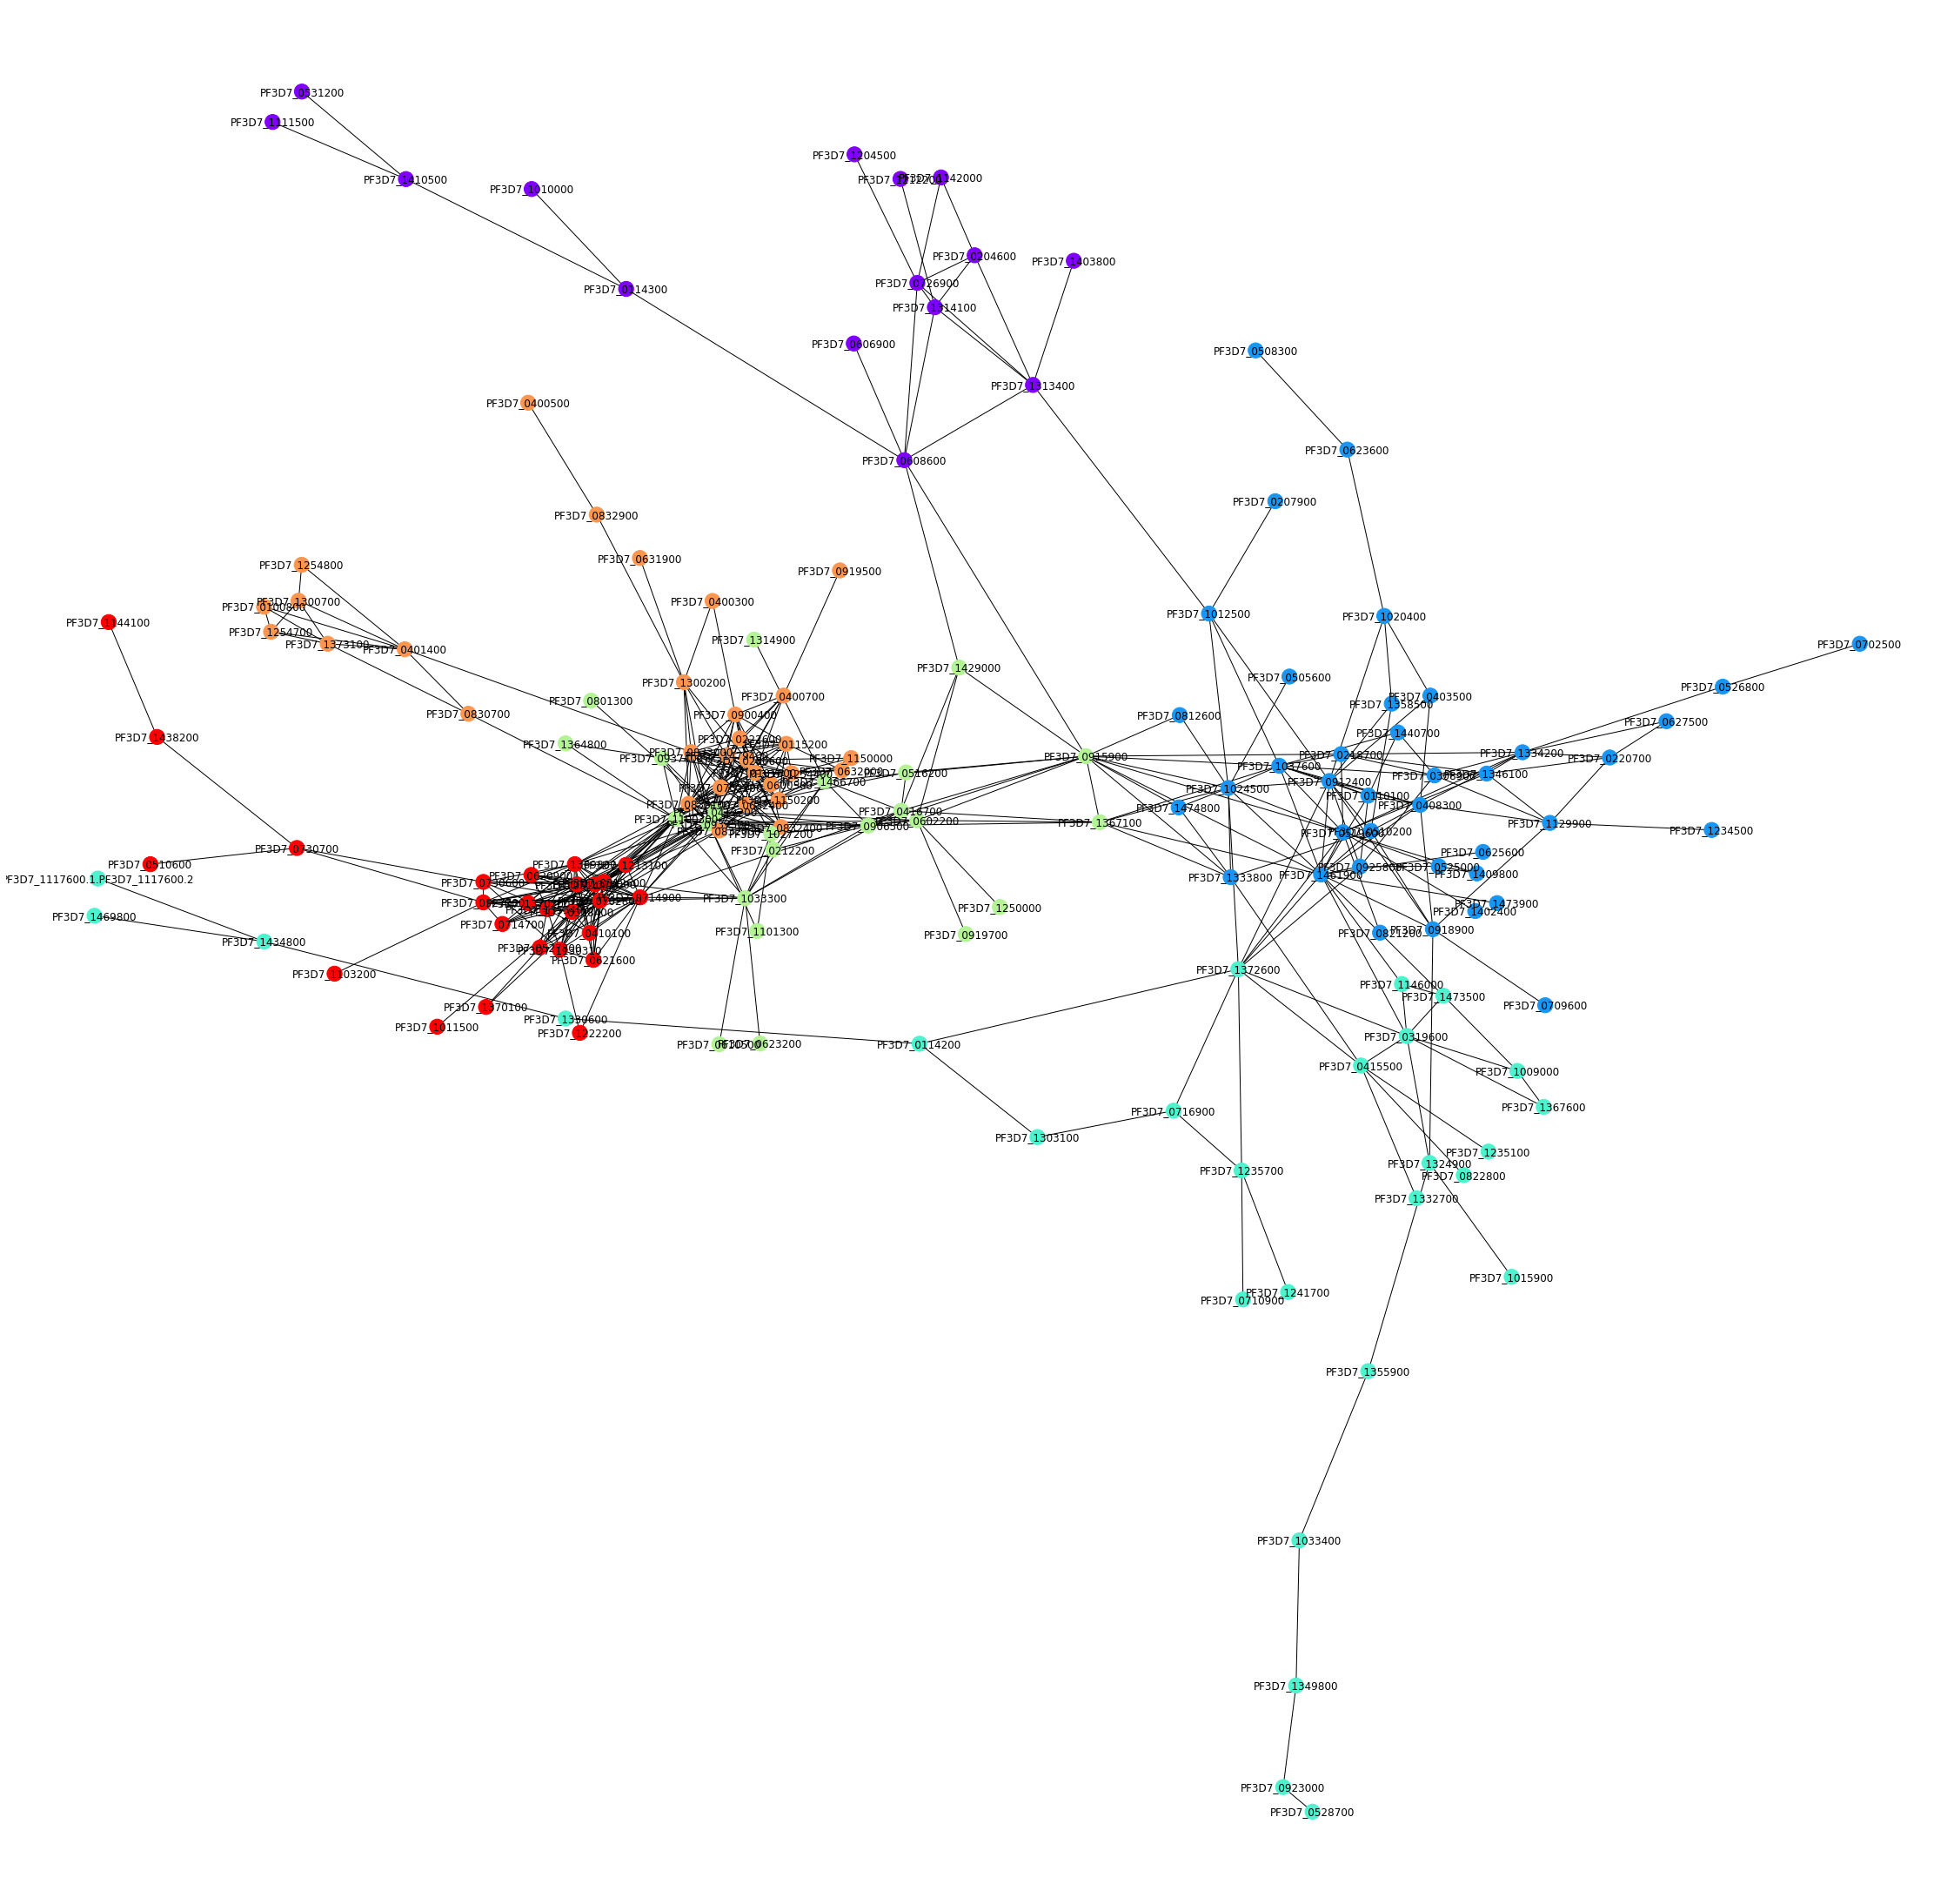

In [24]:
plt.figure(figsize=(40, 40))
nx.draw_networkx(G, pos=nx.layout.spring_layout(G), 
                 node_color=[n[1]['label'] for n in G.nodes(data=True)], 
                 cmap=plt.cm.rainbow
                )
plt.axis('off')
plt.show()